# PaCMAP cluster plot

In [1]:
%load_ext autoreload
%autoreload 2

### testing Spark setup

In [2]:
# let's check that the initial data from murilo is theres
! gcloud storage ls gs://dsgt-clef-birdclef-2024/data/raw/birdclef-2023 | head

gs://dsgt-clef-birdclef-2024/data/raw/birdclef-2023/eBird_Taxonomy_v2021.csv
gs://dsgt-clef-birdclef-2024/data/raw/birdclef-2023/sample_submission.csv
gs://dsgt-clef-birdclef-2024/data/raw/birdclef-2023/train_metadata.csv
gs://dsgt-clef-birdclef-2024/data/raw/birdclef-2023/test_soundscapes/
gs://dsgt-clef-birdclef-2024/data/raw/birdclef-2023/train_audio/


In [3]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-21 19:51:02.749804: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 19:51:07.129896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 19:51:07.129983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 19:51:07.348537: E external/l

In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-birdclef-2024/data"
train_path = "raw/birdclef-2024/train_metadata.csv"
google_emb_path = "processed/google_embeddings/v1"
encodec_emb_path = "processed/encodec_embeddings/v2"
birdnet_emb_path = "processed/birdnet/v1"
unlabeled_path = "intermediate/google_soundscape_embeddings/v1"

# Define the GCS path to the embedding files
train_gcs_path = f"{gcs_path}/{train_path}"
google_gcs_path = f"{gcs_path}/{google_emb_path}"
encodec_gcs_path = f"{gcs_path}/{encodec_emb_path}"
birdnet_gcs_path = f"{gcs_path}/{birdnet_emb_path}"
unlabeled_gcs_path = f"{gcs_path}/{unlabeled_path}"

# Read the Parquet file into a DataFrame
train_df = spark.read.option("header", "true").csv(train_gcs_path)
google_df = spark.read.parquet(google_gcs_path)
encodec_df = spark.read.parquet(encodec_gcs_path)
birdnet_df = spark.read.parquet(birdnet_gcs_path)
# unlabeled_df = spark.read.parquet(unlabeled_gcs_path)

# show
train_df.show(n=3, truncate=50)
google_df.show(n=3, truncate=50)
encodec_df.show(n=3, truncate=50)
birdnet_df.show(n=3, truncate=50)
# unlabeled_df_df.show(n=3, truncate=50)

+-------------+----------------+--------+--------+---------+------------------+----------------------+----------------+--------------------------------------------------+------+---------------------------------+-------------------+
|primary_label|secondary_labels|    type|latitude|longitude|   scientific_name|           common_name|          author|                                           license|rating|                              url|           filename|
+-------------+----------------+--------+--------+---------+------------------+----------------------+----------------+--------------------------------------------------+------+---------------------------------+-------------------+
|       asbfly|              []|['call']| 39.2297| 118.1987|Muscicapa dauurica|Asian Brown Flycatcher|  Matt Slaymaker|Creative Commons Attribution-NonCommercial-Shar...|   5.0|https://www.xeno-canto.org/134896|asbfly/XC134896.ogg|
|       asbfly|              []|['song']|  51.403| 104.6401|Muscicapa da

+--------------------+--------+--------------------------------------------------+--------------------------------------------------+
|                name|chunk_5s|                                         embedding|                                            logits|
+--------------------+--------+--------------------------------------------------+--------------------------------------------------+
|blrwar1/XC650323.ogg|       5|[0.0041362955, 0.027371854, -0.0063488903, -0.0...|[-Infinity, -Infinity, -10.125151, -13.834147, ...|
|blrwar1/XC560248.ogg|      10|[-0.037416093, 0.07239049, -0.035221405, 0.0110...|[-Infinity, -Infinity, -12.585996, -13.561778, ...|
|blrwar1/XC570070.ogg|      11|[-0.033473324, 0.046563875, 0.021181745, 0.0060...|[-Infinity, -Infinity, -9.288566, -13.80399, -1...|
+--------------------+--------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows



+--------------------+--------+--------------------------------------------------+
|                name|chunk_5s|                                         embedding|
+--------------------+--------+--------------------------------------------------+
| eucdov/XC612031.ogg|      22|[819, 819, 819, 819, 819, 819, 819, 676, 819, 8...|
| comros/XC657070.ogg|       5|[738, 133, 876, 475, 1017, 475, 475, 133, 126, ...|
|grewar3/XC420074.ogg|      29|[62, 408, 62, 62, 408, 408, 408, 408, 408, 408,...|
+--------------------+--------+--------------------------------------------------+
only showing top 3 rows



+--------------------+--------+--------------------------------------------------+
|                name|chunk_5s|                                         embedding|
+--------------------+--------+--------------------------------------------------+
|blrwar1/XC826766.ogg|      40|[0.3534707948565483, 0.769614964723587, 0.0, 0....|
| blrwar1/XC26902.ogg|      63|[0.0, 2.4897959232330322, 0.0, 1.33562117815017...|
|blrwar1/XC562674.ogg|       6|[0.03367053437978029, 0.9857755303382874, 0.140...|
+--------------------+--------+--------------------------------------------------+
only showing top 3 rows



In [5]:
train_df.show(vertical=True, n=1, truncate=100)

-RECORD 0---------------------------------------------------------------------
 primary_label    | asbfly                                                    
 secondary_labels | []                                                        
 type             | ['call']                                                  
 latitude         | 39.2297                                                   
 longitude        | 118.1987                                                  
 scientific_name  | Muscicapa dauurica                                        
 common_name      | Asian Brown Flycatcher                                    
 author           | Matt Slaymaker                                            
 license          | Creative Commons Attribution-NonCommercial-ShareAlike 3.0 
 rating           | 5.0                                                       
 url              | https://www.xeno-canto.org/134896                         
 filename         | asbfly/XC134896.ogg             

In [6]:
# Number of distinct bird species
unique_species_count = train_df.select("primary_label").distinct().count()
# print number
print(f"Count of unique bird species in 2024: {unique_species_count}")

Count of unique bird species in 2024: 182


In [7]:
google_df.withColumn("primary_label", F.split(F.col("name"), "/")[0]).groupBy(
    "primary_label"
).agg(F.count("primary_label").alias("n")).orderBy(F.col("n").desc()).show(n=10)

+-------------+-----+
|primary_label|    n|
+-------------+-----+
|      blrwar1|20009|
|       houspa| 9150|
|      grewar3| 6807|
|       commyn| 6367|
|       hoopoe| 5937|
|       comros| 5592|
|       eucdov| 4892|
|       bkwsti| 4612|
|      graher1| 4315|
|       barswa| 4276|
+-------------+-----+
only showing top 10 rows



In [8]:
google_df.groupBy("name").agg(F.count("name").alias("n")).orderBy(
    F.col("n").desc()
).show(n=10)

+--------------------+----+
|                name|   n|
+--------------------+----+
|blrwar1/XC826766.ogg|1193|
|blrwar1/XC826787.ogg| 935|
| commyn/XC548866.ogg| 898|
|blrwar1/XC826057.ogg| 774|
|blrwar1/XC563337.ogg| 561|
| commyn/XC519640.ogg| 527|
|blrwar1/XC572385.ogg| 450|
| commyn/XC519659.ogg| 434|
| commyn/XC546947.ogg| 432|
|blrwar1/XC826043.ogg| 431|
+--------------------+----+
only showing top 10 rows



In [9]:
# top 5 bird species based on unlabeled soundscapes
top_5_bird_species = ["grnsan", "comior1", "lirplo", "bkrfla1", "comtai1"]

In [10]:
from pyspark.sql import DataFrame
from pyspark.sql.window import Window


def prepare_emb_df(
    df: DataFrame,
    train_df: DataFrame,
    col_name: str,
    top_5_bird_species: list,
    samples_per_species: int = 1000,
):
    # Transformation
    primary_df = df.withColumn("primary_label", F.split(F.col("name"), "/")[0])
    # Filter to get only the top species
    subset_df = primary_df.filter(
        F.col("primary_label").isin(top_5_bird_species)
    ).select(["primary_label", col_name])

    # Use window function to assign a random row number to each row within each species group
    window_spec = Window.partitionBy("primary_label").orderBy(F.rand())
    subset_df = subset_df.withColumn("row_num", F.row_number().over(window_spec))

    # Filter to get the first `samples_per_species` rows for each species
    subset_df = subset_df.filter(F.col("row_num") <= samples_per_species).drop(
        "row_num"
    )

    # Add a monotonically increasing index to both DataFrames
    subset_df = subset_df.withColumn("index", F.monotonically_increasing_id())
    train_df = train_df.withColumn("index", F.monotonically_increasing_id())

    # Perform the join on the index
    final_df = subset_df.join(
        train_df.select("index", "scientific_name"), "index"
    ).drop("index")
    return final_df

In [11]:
# prepare dataframes
google_sub_df = prepare_emb_df(google_df, train_df, "embedding", top_5_bird_species)
encodec_sub_df = prepare_emb_df(encodec_df, train_df, "embedding", top_5_bird_species)
birdnet_sub_df = prepare_emb_df(birdnet_df, train_df, "embedding", top_5_bird_species)

In [12]:
google_sub_df.groupBy("primary_label").agg(F.count("primary_label").alias("n")).orderBy(
    F.col("n").desc()
).show(n=10)

+-------------+----+
|primary_label|   n|
+-------------+----+
|      comior1|1000|
|      comtai1|1000|
|       grnsan|1000|
|       lirplo|1000|
|      bkrfla1| 109|
+-------------+----+



In [13]:
google_df.withColumn("primary_label", F.split(F.col("name"), "/")[0]).filter(
    F.col("primary_label").isin(top_5_bird_species)
).groupBy("primary_label").agg(F.count("primary_label").alias("n")).orderBy(
    F.col("n").desc()
).show()

+-------------+----+
|primary_label|   n|
+-------------+----+
|       lirplo|3699|
|       grnsan|2890|
|      comtai1|2127|
|      comior1|1779|
|      bkrfla1| 109|
+-------------+----+



In [14]:
from sklearn.preprocessing import StandardScaler
from pyspark.sql.types import ArrayType, FloatType


# UDF to stack the embeddings
def stack_embeddings(embeddings):
    np.stack(embeddings).tolist()


stack_embeddings_udf = F.udf(stack_embeddings, ArrayType(ArrayType(FloatType())))


def get_embeddings(df: DataFrame, col_name: str):
    # Apply the UDF to stack embeddings
    stacked_df = df.groupBy().agg(
        stack_embeddings_udf(F.collect_list("embedding")).alias("stacked_embeddings")
    )

    # Convert the stacked embeddings to a PySpark DataFrame
    stacked_emb_df = stacked_df.select(
        F.explode("stacked_embeddings").alias("embedding")
    )

    # Convert the embeddings to a NumPy array for scaling
    emb_np = np.array(stacked_emb_df.select("embedding").collect())
    scaled_emb = StandardScaler().fit_transform(emb_np)

    # UMAP reduction
    reducer = umap.UMAP(
        n_neighbors=15, n_components=2, metric="euclidean", random_state=42
    )
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)

    # Convert the original DataFrame to Pandas to return
    pandas_df = df.select([col_name, "species"]).toPandas()

    return pandas_df, embedding, scaled_emb

In [15]:
from sklearn.preprocessing import StandardScaler


def get_pandas_embeddings(df: DataFrame, col_name: str):
    # Convert to Pandas DF
    pandas_df = df.select(["primary_label", "scientific_name", col_name]).toPandas()

    # Extract features and labels
    emb_df = np.stack(pandas_df[col_name].values)
    scaled_emb = StandardScaler().fit_transform(emb_df)

    # UMAP reduction
    reducer = umap.UMAP(
        n_neighbors=15, n_components=2, metric="euclidean", random_state=42
    )
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)
    return pandas_df, embedding, scaled_emb

In [16]:
# google embeddings
google_pandas_df, google_embedding, google_scaled_emb = get_pandas_embeddings(
    df=google_sub_df, col_name="embedding"
)

# encodec embeddings
encodec_pandas_df, encodec_embedding, encodec_scaled_emb = get_pandas_embeddings(
    df=encodec_sub_df, col_name="embedding"
)

# birdnet embeddings
birdnet_pandas_df, birdnet_embedding, birdnet_scaled_emb = get_pandas_embeddings(
    df=birdnet_sub_df, col_name="embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs 

## PaCMAP plot

In [17]:
import pacmap


def get_pacmap_embedding(embedding):
    # PaCMAP
    pacmap_embedding = pacmap.PaCMAP(
        n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0
    )

    # fit the data
    pacmap_transformed = pacmap_embedding.fit_transform(embedding, init="pca")
    return pacmap_transformed

In [18]:
# PaCMAP embeddings
google_pacmap_transformed = get_pacmap_embedding(embedding=google_embedding)
encodec_pacmap_transformed = get_pacmap_embedding(embedding=encodec_embedding)
birdnet_pacmap_transformed = get_pacmap_embedding(embedding=birdnet_embedding)

In [26]:
import os
from pathlib import Path

plt.rc("font", size=14)  # controls default text size


def plot_pacmap_clusters(
    pandas_df_list: list[pd.DataFrame],
    embedding_list: list[pd.DataFrame],
):
    # Plot the data
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=300)
    fig.suptitle(
        f"PaCMAP projection of top 5 bird species",
        fontsize=20,
        weight="bold",
    )
    # titles for each subplot
    titles = ["Bird Vocalization", "BirdNET", "EnCodec"]

    for i, pandas_df in enumerate(pandas_df_list):
        # Create a scatter plot, color-coded by new species_idx
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        top_species_idx = pandas_df["scientific_name"].value_counts().nlargest(5).index
        species_to_color = {
            species: colors[i] for i, species in enumerate(top_species_idx)
        }
        # Map species IDs to colors for plotting
        color_list = pandas_df["scientific_name"].map(species_to_color).tolist()

        for species, color in species_to_color.items():
            # Select embeddings for the current species
            idx = pandas_df["scientific_name"] == species
            axes[i].scatter(
                embedding_list[i][idx, 0],
                embedding_list[i][idx, 1],
                c=color,
                label=species,
                s=5,
                alpha=0.7,
                linewidth=0.5,
            )
        axes[i].set_title(f"{titles[i]}", fontsize=16)
        axes[i].grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
        # axes[i].legend(ncol=5, loc="best", fontsize="small")
        for spine in ["top", "right", "bottom", "left"]:
            axes[i].spines[spine].set_visible(False)
    fig.tight_layout(pad=0.5)
    path = Path(os.getcwd()).parents[1]
    lgnd = plt.legend(
        ncol=5,
        loc="lower right",
        # title="Species Names",
        fontsize="medium",
        bbox_to_anchor=(0.95, -0.2),
        shadow=True,
    )
    for handle in lgnd.legend_handles:
        handle.set_sizes([60.0])
    plt.savefig(f"{path}/figures/pacmap_cluster.png", bbox_inches="tight")
    plt.show()

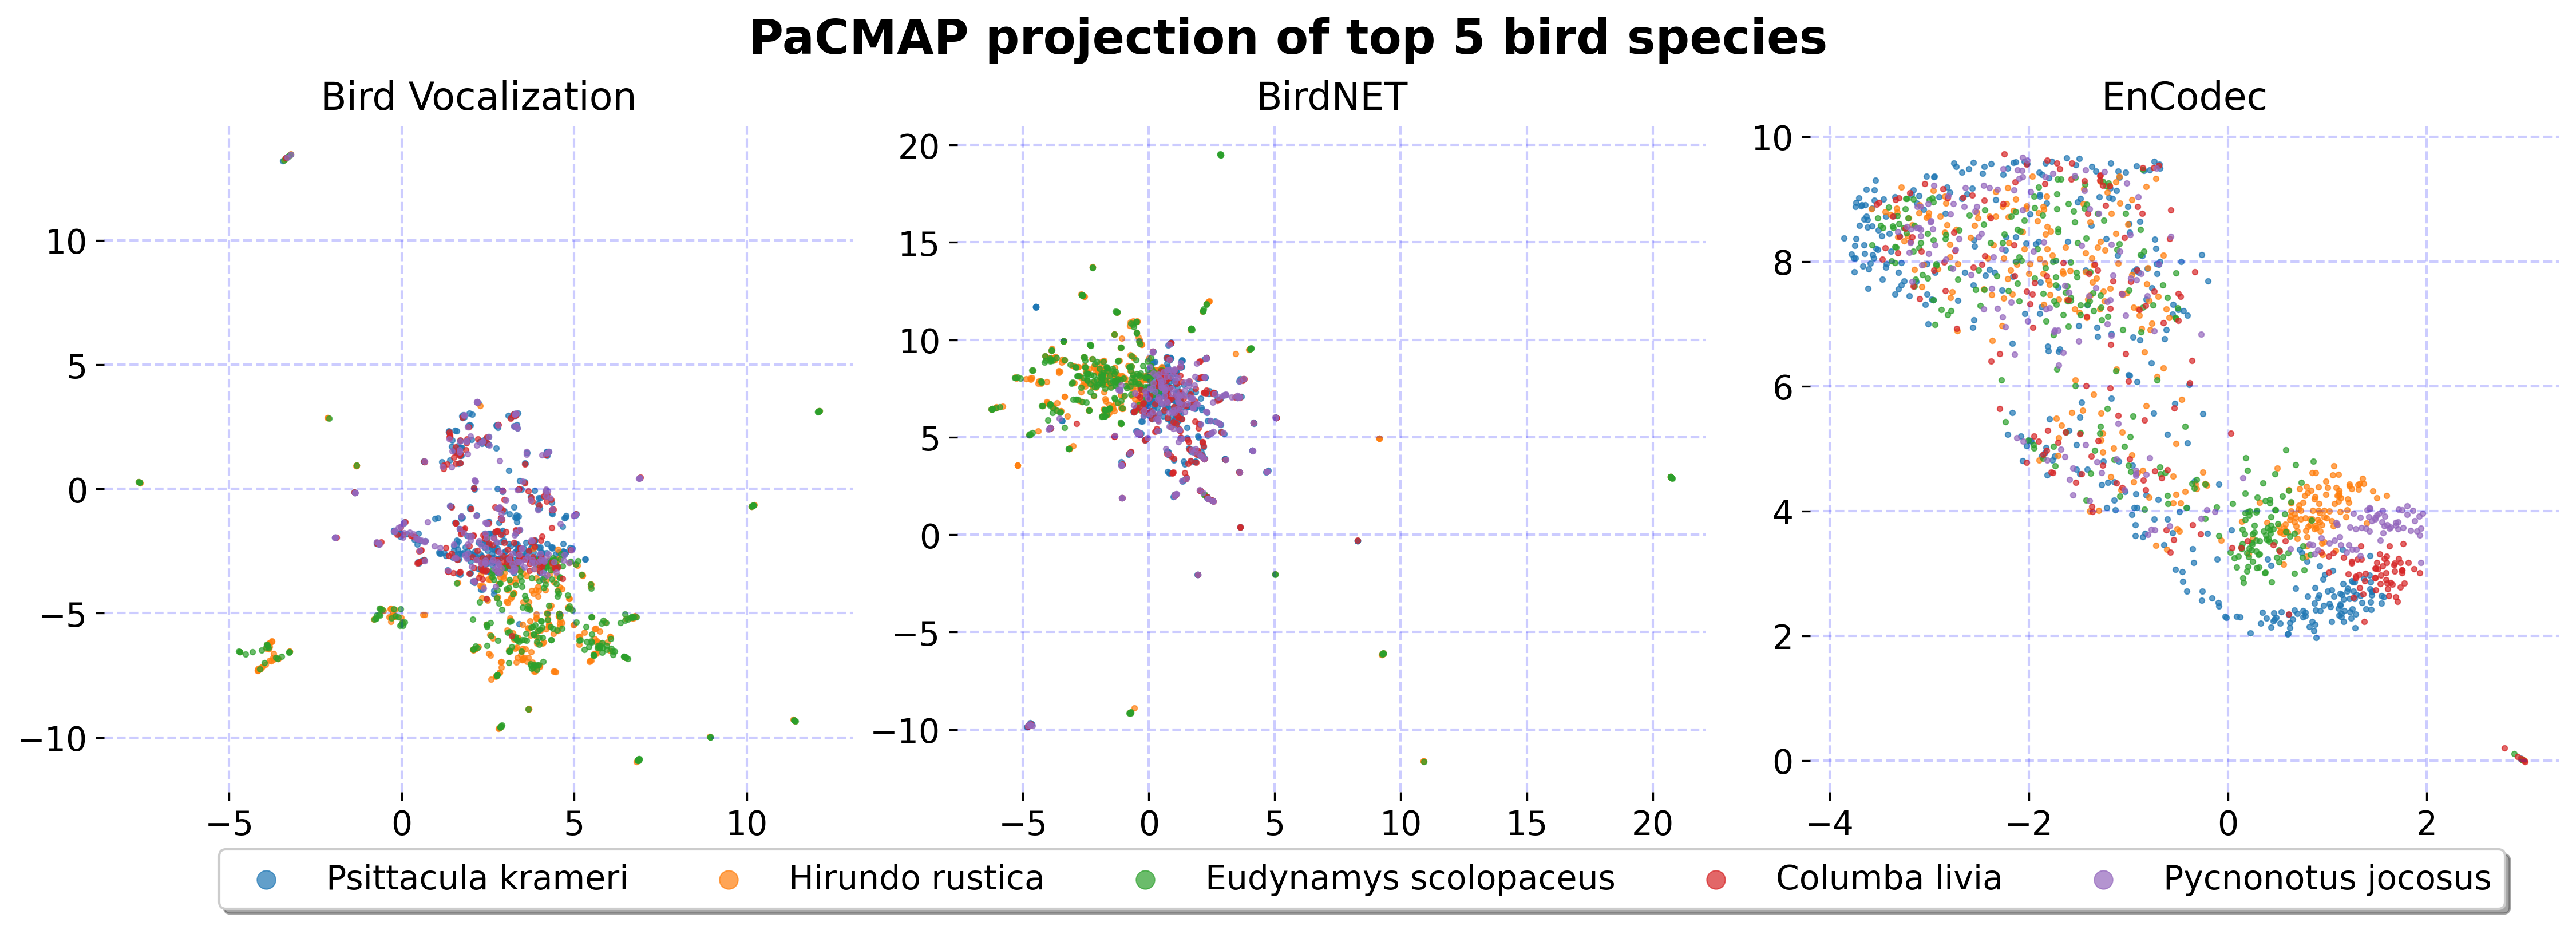

In [27]:
pandas_df_list = [google_pandas_df, birdnet_pandas_df, encodec_pandas_df]
embedding_list = [google_embedding, birdnet_embedding, encodec_embedding]
plot_pacmap_clusters(pandas_df_list, embedding_list)